## 0. Load libraries and custom functions

In [1]:
%reset -f

from subwayfunctions7 import removeSpecialCharactersFromStationName,removeSpecialCharactersFromStationTimestamps,\
                createStationCountsByTime,computeTrafficRidershipCounts,removeOutlier,removeSpecialCharactersFromStopName,\
                matchStationNames,combineGTFSStopsAndStationData,plot_total_trips,plot_on_map_entries,plot_on_map_exits

from sqlalchemy import create_engine
import pandas as pd
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import plotly
import geopandas as gpd


## * If CSV file is already available, download them and start directly from Step 3.2. Read from Subway.csv

## 1. Load subway turnstile data
- Download Turnstile data for first six months of 2022 using this script get_turnstile_data.py.
- Usage get_turnstile_data.py "(2201|2202|2203|2204|2205|2206)"
<br><br>
- Note: Subway data from Jan-Jun 2022 will be used due to limited resources.
- Data source: Metropolitan Transportation Authority(MTA) http://web.mta.info/developers/

In [2]:

engine = create_engine("sqlite:///C:\\Users\\panch\\finaldeliverable\\NYC-Transportation-and-Socioeconomic-Data-Analysis\\subway\\notebooks\\mta_data.db")
mta_df = pd.read_sql('SELECT * FROM mta_data;', engine)

#Cleanup data from station names
mta_df = mta_df.rename(columns={'C/A': 'control_area', 'UNIT': 'unit', 'SCP': 'subunit_channel_pos', 'STATION':'station', 'LINENAME':'subway_lines', 'DIVISION':'division', 'DATE':'date', 'TIME':'time', 'DESC':'desc', 'ENTRIES':'entries', 'EXITS':'exits'})
mta_df = removeSpecialCharactersFromStationName(mta_df)
mta_df = removeSpecialCharactersFromStationTimestamps(mta_df)

mta_df['subunit_channel_pos'] = mta_df['subunit_channel_pos'].str.replace('-', '_')

# Create UniqueId column for grouping by 
mta_df['unique_id'] = mta_df['control_area'] + '_' + mta_df['unit'] + '_' + mta_df['subunit_channel_pos'] + '_' + mta_df['station'] + '_' + mta_df['date'] + '_' + mta_df['time'] + '_' + mta_df['desc']
mta_df['date_time'] = mta_df.date + ' ' + mta_df.time
mta_df.date_time = pd.to_datetime(mta_df['date_time'], format = '%m_%d_%Y %H_%M_%S')
mta_df = mta_df[mta_df.desc != 'RECOVR_AUD']

mta_df = computeTrafficRidershipCounts(mta_df)
mta_df.fillna(0, inplace=True)

# Elimate outliers in the data by reducing to the 99th percentile. 
mta_df = removeOutlier(mta_df)

mta_df = mta_df[(mta_df['date_time']>pd.Timestamp(2022,1,1)) & (mta_df['date_time']<pd.Timestamp(2022,7,1))]

mta_df = createStationCountsByTime(mta_df, 'date_time', col_name='Station_Readings_Entry')
mta_df = createStationCountsByTime(mta_df, 'date_time', col_name='Station_Readings_Exit')

#print('Stations With passenger counts and timestamps ,net entries and net exits and net traffic(which is sum of net entry and exit')


"date_time" splitted into multiple columns.

"date_time" splitted into multiple columns.



<br>
Concatenate yellow and green taxi dataframes as a single dataframe since they mostly share common columns and the distinction between the two is not necessary in our analysis.

## 2. Map Subway stations with Borough and CDTA using Lat and Long geometry
### 2-1. Download  .shp file as dataframe and map station lat and long with CDTA polygon.
- Note: The taxi zones are roughly based on NYC Department of City Planning’s Neighborhood Tabulation Areas (NTAs).
- Reference: https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc
<br><br>
- Note: Community District Tabulation Areas (CDTAs), which closely approximate Community Districts (CDs).
- Reference: https://storymaps.arcgis.com/stories/d30850ba28944619b94e8ee4f746d5c4

In [3]:
cols_to_keep = ["station","entries", "exits","net_entries","net_exits","net_traffic","Station_Readings_Exit_weekday","Station_Readings_Exit_year_month","Station_Readings_Exit_day","Station_Readings_Exit_hour","Station_Readings_Entry_weekday","Station_Readings_Entry_year_month","Station_Readings_Entry_day","Station_Readings_Entry_hour"]
group_cols = ["net_traffic"]

station_data_gtfs = pd.read_csv('../data/subway/stationnames.csv')
station_data_gtfs = removeSpecialCharactersFromStopName(station_data_gtfs)

mta_df = mta_df[cols_to_keep]
                
top_stations = mta_df.groupby('station')[group_cols].sum().sort_values(by='net_traffic', ascending=False).reset_index().copy()
top_stations,station_data_gtfs = matchStationNames(top_stations,station_data_gtfs)

#Merge station names from GTFS and Turnstile data for mapping CDTA
top_station_df = pd.merge(top_stations, right=station_data_gtfs, left_on='matches', right_on='stop_name', how='left')

#Merge CDTA Code and Burough code into single DF
stationWithCdta,cdta_dict = combineGTFSStopsAndStationData(top_station_df)
stationWithCdta.dropna(subset=['station'], how='all', inplace=True)

stationWithCdta = stationWithCdta.rename(columns={'CDTA2020': 'cdtaCode'})

#station name is mapped to wrong borough
stationWithCdta = stationWithCdta.drop(stationWithCdta.index[226])

#Create CDTA Dictionary
cdta_station_dict = stationWithCdta[["cdtaCode", "station"]].set_index("station").to_dict()["cdtaCode"]



C:\Users\panch\finaldeliverable\NYC-Transportation-and-Socioeconomic-Data-Analysis\subway\notebooks\subwayfunctions7.py:80: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.stop_name = df.stop_name.str.replace("(","")
C:\Users\panch\finaldeliverable\NYC-Transportation-and-Socioeconomic-Data-Analysis\subway\notebooks\subwayfunctions7.py:81: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.stop_name = df.stop_name.str.replace(")","")
C:\Users\panch\finaldeliverable\NYC-Transportation-and-Socioeconomic-Data-Analysis\subway\notebooks\subwayfunctions7.py:83: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character 

### 2-2. Load Net Entries and Exits for each CDTA

In [4]:
net_entry_stations = mta_df.groupby(['station'])["net_entries"].sum().reset_index().copy()
net_exit_stations = mta_df.groupby(['station'])["net_exits"].sum().reset_index().copy()

net_entry_stations['cdtaCode'] = net_entry_stations['station'].map(cdta_station_dict).dropna()
net_exit_stations['cdtaCode'] = net_exit_stations['station'].map(cdta_station_dict).dropna()

net_entry_cdta = net_entry_stations.groupby(['cdtaCode']).sum()
net_exit_cdta = net_exit_stations.groupby(['cdtaCode']).sum()

average_entry_cdta = net_entry_stations.groupby(['cdtaCode']).mean()
average_exit_cdta = net_exit_stations.groupby(['cdtaCode']).mean()

stations_list = mta_df.groupby(['station']).count().reset_index().copy()
stations_list['cdtaCode'] = stations_list['station'].map(cdta_station_dict).dropna()

station_counts= stations_list.groupby(['cdtaCode']).count()
station_counts = station_counts[['station']]
station_counts = station_counts.rename(columns={'station': 'station_counts'})


C:\Users\panch\AppData\Local\Temp\ipykernel_21232\2860537520.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  net_entry_cdta = net_entry_stations.groupby(['cdtaCode']).sum()
C:\Users\panch\AppData\Local\Temp\ipykernel_21232\2860537520.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  net_exit_cdta = net_exit_stations.groupby(['cdtaCode']).sum()
C:\Users\panch\AppData\Local\Temp\ipykernel_21232\2860537520.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns

### 2-3. Load CDTA Day wise (1 to 31 ) NetEntries and NetExits

In [5]:
day_entry_stations = mta_df.groupby(['Station_Readings_Entry_day','station'])["net_entries"].sum().reset_index().copy()
day_exit_stations = mta_df.groupby(['Station_Readings_Exit_day','station'])["net_exits"].sum().reset_index().copy()

day_entry_stations['cdtaCode'] = day_entry_stations['station'].map(cdta_station_dict).dropna()
day_exit_stations['cdtaCode'] = day_exit_stations['station'].map(cdta_station_dict).dropna()

## Entry day count by CDTA
entry_day_count_cdta = day_entry_stations.groupby(['cdtaCode', 'Station_Readings_Entry_day']).sum().reset_index()\
    [['cdtaCode', 'Station_Readings_Entry_day','net_entries']].pivot(index='cdtaCode', columns="Station_Readings_Entry_day", values="net_entries")
entry_day_count_cdta.columns = ["Entry_total_trip_count_day_" + str(col) for col in entry_day_count_cdta.columns]

## Exit day count by CDTA
exit_day_count_cdta = day_exit_stations.groupby(['cdtaCode', 'Station_Readings_Exit_day']).sum().reset_index()\
    [['cdtaCode', 'Station_Readings_Exit_day','net_exits']].pivot(index='cdtaCode', columns="Station_Readings_Exit_day", values="net_exits")
exit_day_count_cdta.columns = ["Exit_total_trip_count_day_" + str(col) for col in exit_day_count_cdta.columns]


C:\Users\panch\AppData\Local\Temp\ipykernel_21232\3878387.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  entry_day_count_cdta = day_entry_stations.groupby(['cdtaCode', 'Station_Readings_Entry_day']).sum().reset_index()\
C:\Users\panch\AppData\Local\Temp\ipykernel_21232\3878387.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  exit_day_count_cdta = day_exit_stations.groupby(['cdtaCode', 'Station_Readings_Exit_day']).sum().reset_index()\


### 2-4. Load CDTA Hour wise (1 to 24 ) NetEntries and NetExits.

In [6]:
hour_entry_stations = mta_df.groupby(['Station_Readings_Entry_hour','station'])["net_entries"].sum().reset_index().copy()
hour_exit_stations = mta_df.groupby(['Station_Readings_Exit_hour','station'])["net_exits"].sum().reset_index().copy()

hour_entry_stations['cdtaCode'] = hour_entry_stations['station'].map(cdta_station_dict).dropna()
hour_exit_stations['cdtaCode'] = hour_exit_stations['station'].map(cdta_station_dict).dropna()

 ## Entry Hour count by CDTA
entry_hour_count_cdta = hour_entry_stations.groupby(['cdtaCode', 'Station_Readings_Entry_hour']).sum().reset_index()\
    [['cdtaCode', 'Station_Readings_Entry_hour','net_entries']].pivot(index='cdtaCode', columns="Station_Readings_Entry_hour", values="net_entries")
entry_hour_count_cdta.columns = ["Entry_total_trip_count_hour_" + str(col) for col in entry_hour_count_cdta.columns]

 ##  Exit Hour count by CDTA
exit_hour_count_cdta = hour_exit_stations.groupby(['cdtaCode', 'Station_Readings_Exit_hour']).sum().reset_index()\
    [['cdtaCode', 'Station_Readings_Exit_hour','net_exits']].pivot(index='cdtaCode', columns="Station_Readings_Exit_hour", values="net_exits")
exit_hour_count_cdta.columns = ["Exit_total_trip_count_hour_" + str(col) for col in exit_hour_count_cdta.columns]


C:\Users\panch\AppData\Local\Temp\ipykernel_21232\2866875340.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  entry_hour_count_cdta = hour_entry_stations.groupby(['cdtaCode', 'Station_Readings_Entry_hour']).sum().reset_index()\
C:\Users\panch\AppData\Local\Temp\ipykernel_21232\2866875340.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  exit_hour_count_cdta = hour_exit_stations.groupby(['cdtaCode', 'Station_Readings_Exit_hour']).sum().reset_index()\


### 2-5. Load CDTA Weekday wise (Sunday to Saturday ) NetEntries and NetExits.

In [7]:
weekday_entry_stations = mta_df.groupby(['Station_Readings_Entry_weekday','station'])["net_entries"].sum().reset_index().copy()
weekday_exit_stations = mta_df.groupby(['Station_Readings_Exit_weekday','station'])["net_exits"].sum().reset_index().copy()

weekday_entry_stations['cdtaCode'] = weekday_entry_stations['station'].map(cdta_station_dict).dropna()
weekday_exit_stations['cdtaCode'] = weekday_exit_stations['station'].map(cdta_station_dict).dropna()

 ## Entry Weekday count by CDTA
entry_weekday_count_cdta = weekday_entry_stations.groupby(['cdtaCode', 'Station_Readings_Entry_weekday']).sum().reset_index()\
    [['cdtaCode', 'Station_Readings_Entry_weekday','net_entries']].pivot(index='cdtaCode', columns="Station_Readings_Entry_weekday", values="net_entries")
entry_weekday_count_cdta.columns = ["Entry_total_trip_count_weekday_" + str(col) for col in entry_weekday_count_cdta.columns]

 ## Exit Weekday count by CDTA
exit_weekday_count_cdta = weekday_exit_stations.groupby(['cdtaCode', 'Station_Readings_Exit_weekday']).sum().reset_index()\
    [['cdtaCode', 'Station_Readings_Exit_weekday','net_exits']].pivot(index='cdtaCode', columns="Station_Readings_Exit_weekday", values="net_exits")
exit_weekday_count_cdta.columns = ["Exit_total_trip_count_weekday_" + str(col) for col in exit_weekday_count_cdta.columns]


C:\Users\panch\AppData\Local\Temp\ipykernel_21232\1677994790.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  entry_weekday_count_cdta = weekday_entry_stations.groupby(['cdtaCode', 'Station_Readings_Entry_weekday']).sum().reset_index()\
C:\Users\panch\AppData\Local\Temp\ipykernel_21232\1677994790.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  exit_weekday_count_cdta = weekday_exit_stations.groupby(['cdtaCode', 'Station_Readings_Exit_weekday']).sum().reset_index()\


### 2-6. Load CDTA  Year and Month wise NetEntries and NetExits.

In [8]:
print(mta_df.columns)
year_month_entry_stations = mta_df.groupby(['Station_Readings_Entry_year_month','station'])["net_entries"].sum().reset_index().copy()
year_month_exit_stations = mta_df.groupby(['Station_Readings_Exit_year_month','station'])["net_exits"].sum().reset_index().copy()

year_month_entry_stations['cdtaCode'] = year_month_entry_stations['station'].map(cdta_station_dict).dropna()
year_month_exit_stations['cdtaCode'] = year_month_exit_stations['station'].map(cdta_station_dict).dropna()

 ## Entry Year and Monthwise count by CDTA
entry_year_month_count_cdta = year_month_entry_stations.groupby(['cdtaCode', 'Station_Readings_Entry_year_month']).sum().reset_index()\
    [['cdtaCode', 'Station_Readings_Entry_year_month','net_entries']].pivot(index='cdtaCode', columns="Station_Readings_Entry_year_month", values="net_entries")
entry_year_month_count_cdta.columns = ["Entry_total_trip_count_year_month_" + str(col) for col in entry_year_month_count_cdta.columns]

 ## Exit Year and Monthwise count by CDTA
exit_year_month_count_cdta = year_month_exit_stations.groupby(['cdtaCode', 'Station_Readings_Exit_year_month']).sum().reset_index()\
    [['cdtaCode', 'Station_Readings_Exit_year_month','net_exits']].pivot(index='cdtaCode', columns="Station_Readings_Exit_year_month", values="net_exits")
exit_year_month_count_cdta.columns = ["Exit_total_trip_count_year_month_" + str(col) for col in exit_year_month_count_cdta.columns]


Index(['station', 'entries', 'exits', 'net_entries', 'net_exits',
       'net_traffic', 'Station_Readings_Exit_weekday',
       'Station_Readings_Exit_year_month', 'Station_Readings_Exit_day',
       'Station_Readings_Exit_hour', 'Station_Readings_Entry_weekday',
       'Station_Readings_Entry_year_month', 'Station_Readings_Entry_day',
       'Station_Readings_Entry_hour'],
      dtype='object')


C:\Users\panch\AppData\Local\Temp\ipykernel_21232\1543287883.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  entry_year_month_count_cdta = year_month_entry_stations.groupby(['cdtaCode', 'Station_Readings_Entry_year_month']).sum().reset_index()\
C:\Users\panch\AppData\Local\Temp\ipykernel_21232\1543287883.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  exit_year_month_count_cdta = year_month_exit_stations.groupby(['cdtaCode', 'Station_Readings_Exit_year_month']).sum().reset_index()\


In [9]:
### 2-7. Load CDTA Buroughs.

In [10]:
cdta_burough_poly_df = stationWithCdta.set_index("cdtaCode")[["CDTAName", "borough","geometry"]].drop_duplicates()
cdta_burough_poly_df = cdta_burough_poly_df.drop('BK08')

condition = ~((cdta_burough_poly_df['CDTAName'] == 'BX08 Riverdale-Kingsbridge-Marble Hill (CD 8 Approximation)') & (cdta_burough_poly_df['borough'] == 'M'))
cdta_burough_poly_df = cdta_burough_poly_df[ condition ]


## 3. Data cleaning and feature engineering
### 3-1. Combine all CDTA breakdown into single dataframe.

In [11]:
cdta_df = pd.concat([cdta_burough_poly_df,station_counts,net_entry_cdta,net_exit_cdta,entry_day_count_cdta,exit_day_count_cdta,entry_hour_count_cdta,exit_hour_count_cdta,entry_weekday_count_cdta,exit_weekday_count_cdta,entry_year_month_count_cdta,exit_year_month_count_cdta], axis=1)
cdta_df.to_csv('subway_cdta.csv')


### 3-2. Load the dataframe again from subway CDTA.csv

In [12]:
%%time
cdta_subway_df = pd.read_csv ('subway_cdta.csv')
print(cdta_subway_df.columns)
print('loaded subway cdta data again..')

Index(['cdtaCode', 'CDTAName', 'borough', 'geometry', 'station_counts',
       'net_entries', 'net_exits', 'Entry_total_trip_count_day_1',
       'Entry_total_trip_count_day_2', 'Entry_total_trip_count_day_3',
       ...
       'Entry_total_trip_count_year_month_2022-03',
       'Entry_total_trip_count_year_month_2022-04',
       'Entry_total_trip_count_year_month_2022-05',
       'Entry_total_trip_count_year_month_2022-06',
       'Exit_total_trip_count_year_month_2022-01',
       'Exit_total_trip_count_year_month_2022-02',
       'Exit_total_trip_count_year_month_2022-03',
       'Exit_total_trip_count_year_month_2022-04',
       'Exit_total_trip_count_year_month_2022-05',
       'Exit_total_trip_count_year_month_2022-06'],
      dtype='object', length=143)
loaded subway cdta data again..
CPU times: total: 31.2 ms
Wall time: 31.9 ms


### 4. Visualizations
### 4-1. Based on pickup CDTA
#### 4-1-1. Plot total and monthly trip count for each day, hour, and weekday for each borough.

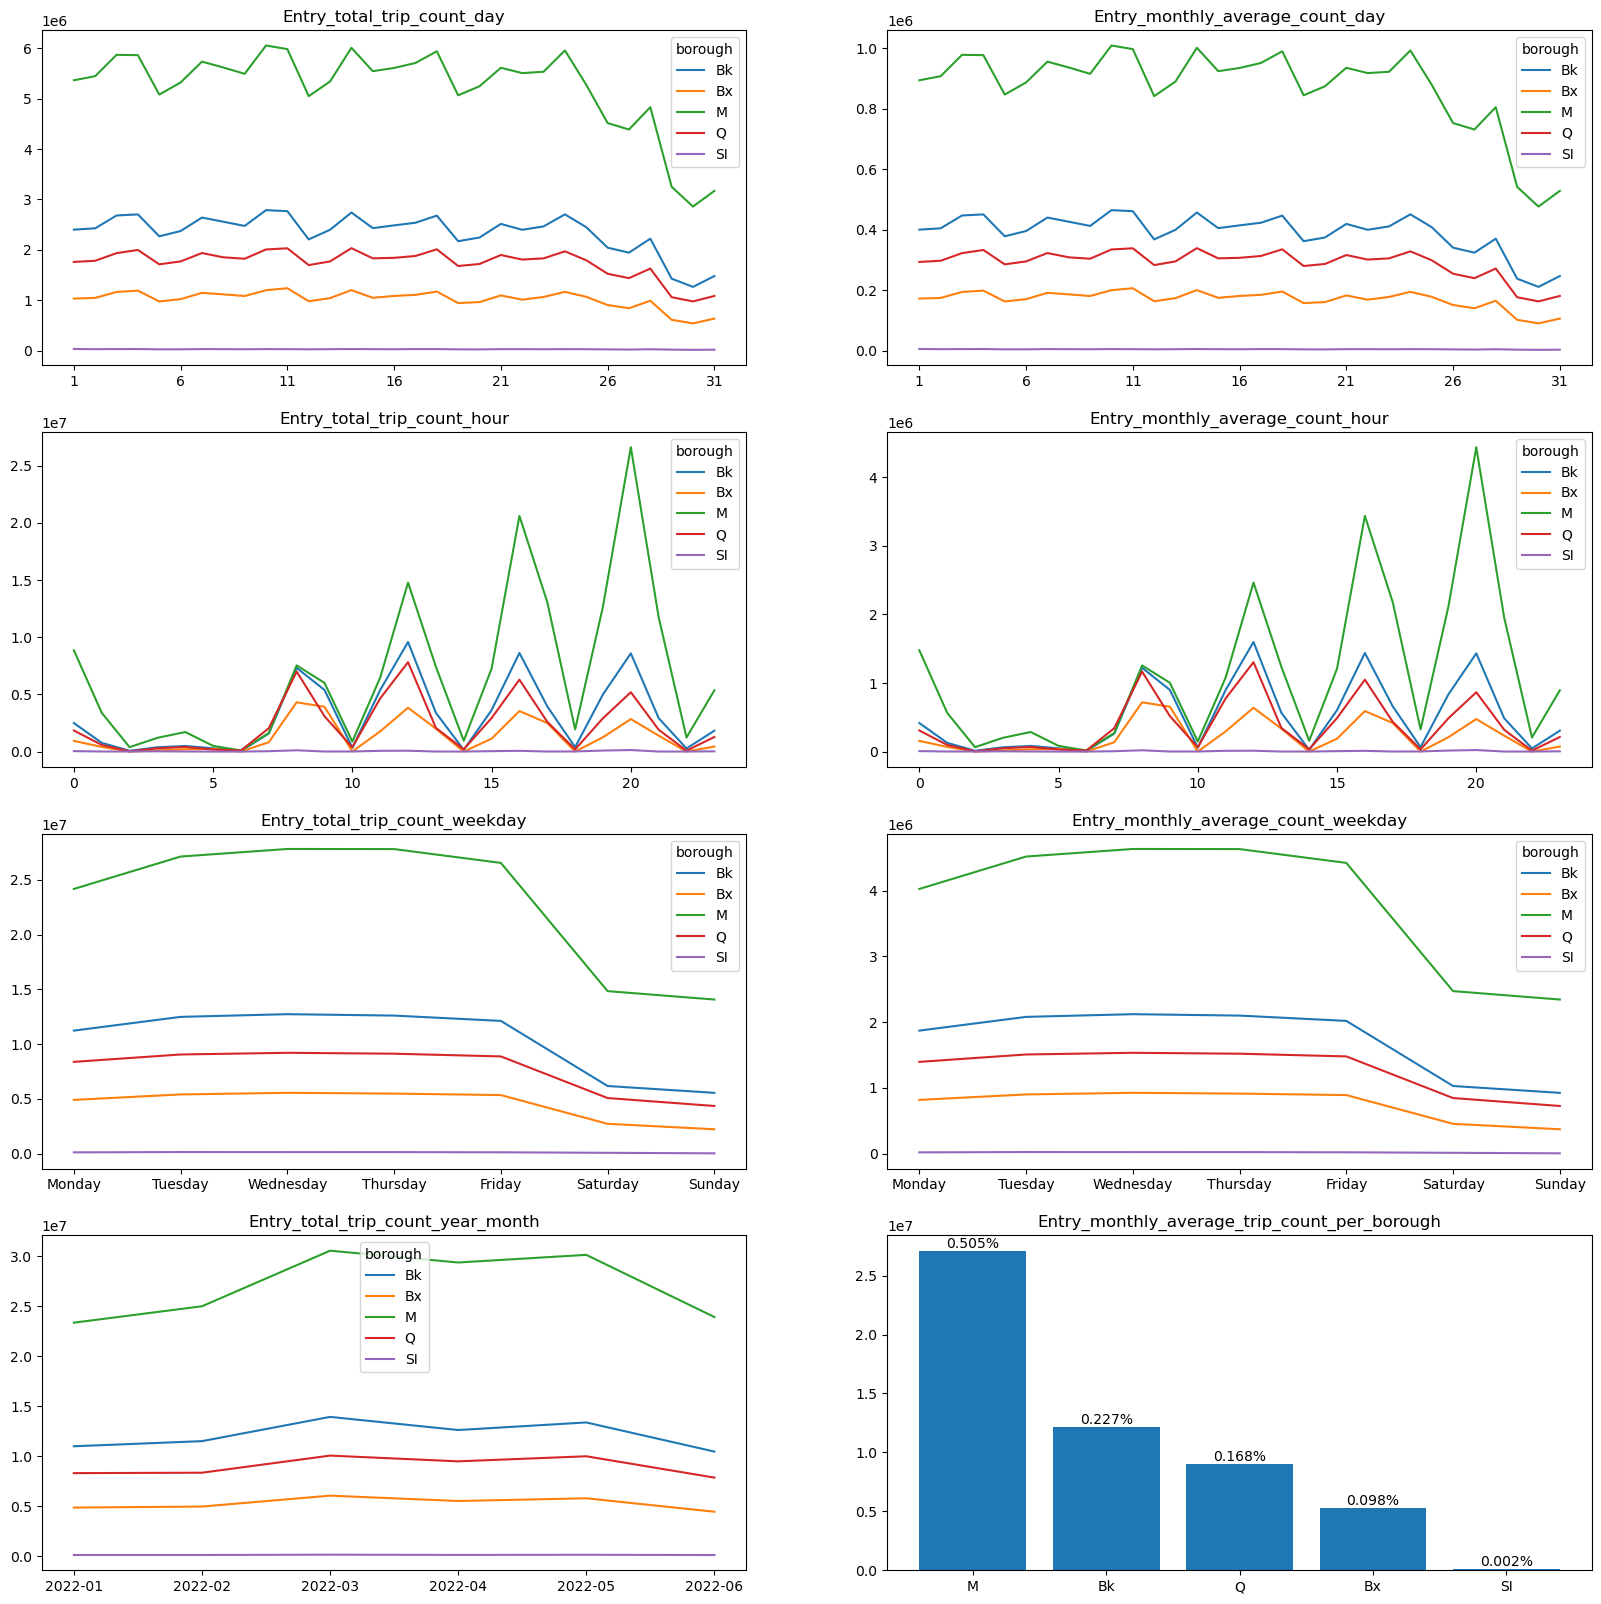

In [13]:
plot_total_trips(cdta_subway_df, pu_do = "Entry", single_month=False, year_month=None, save_png=False)

#### 4-1-2. Plot the same variables as above but for each month in Jan-Jun 2022.

In [14]:
#plot_trips_per_month(dfs, year_months, pu_do="PU")

![gif](data/png/trip_counts_per_month.gif)

#### 4-1-3. Plot sum and average of passenger count, total fare, congestion charge, airport fee, duration, trip distance, minute per mile, and total trip count for each CDTA on the map of NYC.

AttributeError: 'Line2D' object has no property 'cax'

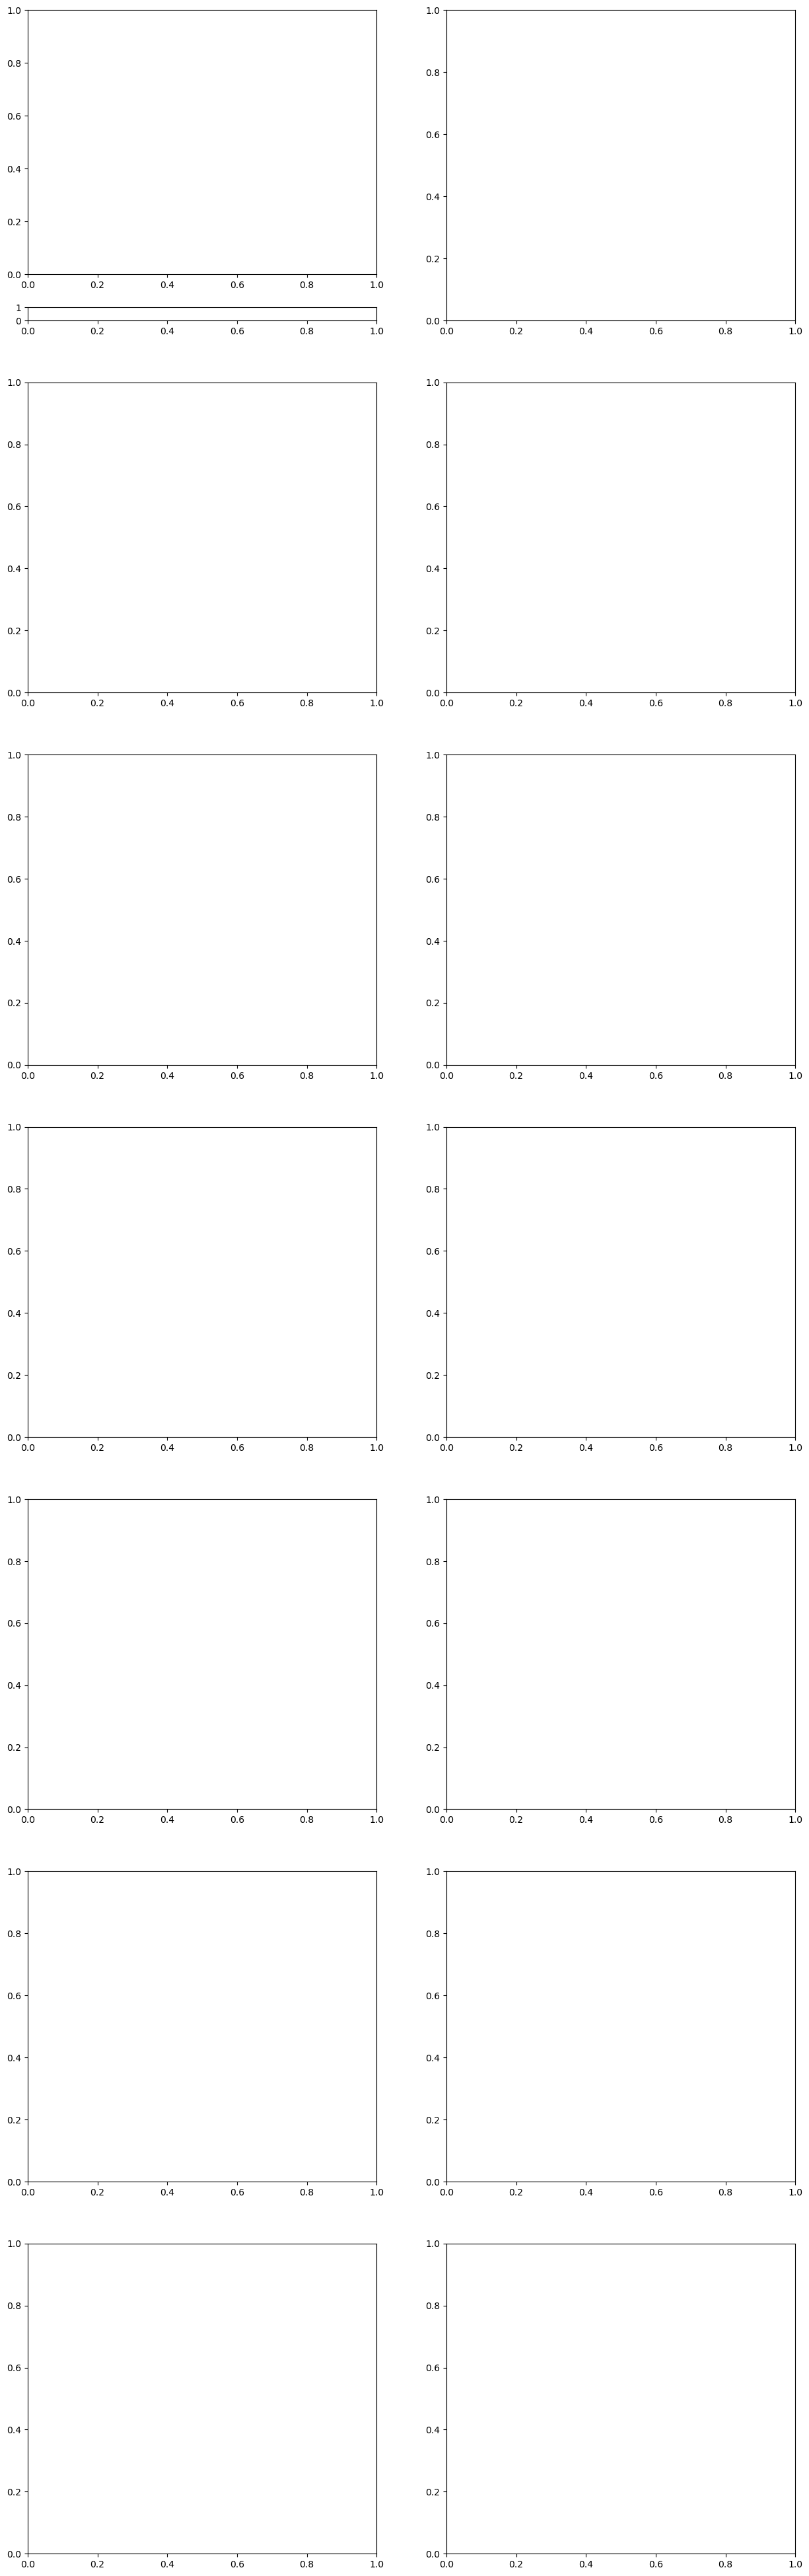

In [15]:
cols = [
    f'net_entries'
]
plot_on_map_entries(cdta_subway_df, cols)

#### 4-1-4. Plot the same variables as above but excluding Manhattan, where around 90% of taxi trips happened, to see if there are any interesting patterns in other boroughs.

In [ ]:
#plot_on_map(cdta_df[cdta_df['borough'] != "Manhattan"], pu_do="PU")

### 4-2. Based on dropoff CDTA
#### 4-2-1. Plot total and monthly trip count for each day, hour, and weekday for each borough.

In [ ]:
#plot_total_trips(cdta_df, pu_do = "DO", single_month=False, year_month=None, save_png=False)

#### 4-2-2. Plot the same variables as above but for each month in Jan-Jun 2022.

In [ ]:
#plot_trips_per_month(dfs, year_months, pu_do="DO")

#### 4-2-3. Plot sum and average of passenger count, total fare, congestion charge, airport fee, duration, trip distance, minute per mile, and total trip count for each CDTA on the map of NYC.

In [ ]:
#plot_on_map(cdta_df, pu_do="DO")

#### 4-2-4. Plot the same variables as above but excluding Manhattan, where around 90% of taxi trips happened, to see if there are any interesting patterns in other boroughs.

In [ ]:
#plot_on_map(cdta_df[cdta_df['borough'] != "Manhattan"], pu_do="DO")